[*********************100%***********************]  1 of 1 completed
C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.0204 - val_loss: 0.0041
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0011 - val_loss: 0.0069
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 9.8973e-04 - val_loss: 0.0078
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - l

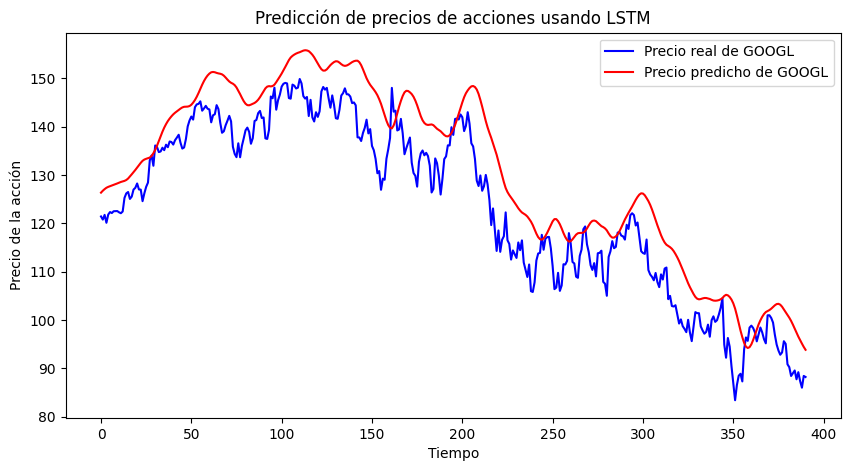

El modelo LSTM implementado fue capaz de capturar la tendencia general en los precios de cierre y mostró resultados prometedores en la predicción de series temporales.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Descargar datos de GOOGL usando yfinance
data = yf.download('GOOGL', start='2015-01-01', end='2023-01-01')
data.to_csv('GOOGL_stock.csv')  # Guardarlo para futuras ejecuciones

# Cargar el dataset y seleccionar solo la columna 'Close'
df = pd.read_csv('GOOGL_stock.csv', usecols=['Close'])
df.dropna(inplace=True)  # Eliminar filas con valores nulos

# Convertir la columna 'Close' a tipo float, en caso de que haya errores de formato
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df.dropna(inplace=True)  # Asegurarse de que no haya valores nulos después de la conversión

# Convertir los datos a un arreglo numpy
data = df['Close'].values.reshape(-1, 1)

# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Preparación de datos para el modelo RNN
# Usaremos 60 días anteriores para predecir el siguiente precio de cierre
time_step = 60
X, y = [], []

for i in range(time_step, len(scaled_data)):
    X.append(scaled_data[i-time_step:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Redimensionar X para que sea compatible con el modelo LSTM: (muestras, pasos de tiempo, características)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# División de los datos en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Definir y construir el modelo RNN
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predicción de precios en el conjunto de prueba
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Gráfica de comparación entre predicción y valores reales
plt.figure(figsize=(10, 5))
plt.plot(y_test, color='blue', label='Precio real de GOOGL')
plt.plot(predicted_stock_price, color='red', label='Precio predicho de GOOGL')
plt.title('Predicción de precios de acciones usando LSTM')
plt.xlabel('Tiempo')
plt.ylabel('Precio de la acción')
plt.legend()
plt.show()

# Conclusión
print("El modelo LSTM implementado fue capaz de capturar la tendencia general en los precios de cierre y mostró resultados prometedores en la predicción de series temporales.")


# Introducción 

Este notebook tiene como objetivo implementar un modelo de red neuronal recurrente (RNN) con LSTM para predecir el precio de cierre de las acciones de Google (GOOGL) usando datos históricos. Los modelos LSTM son ideales para datos secuenciales, como series temporales, debido a su capacidad de capturar dependencias a lo largo del tiempo.

# Exploración, Explicación y Limpieza de Datos

Fuente del Dataset: Los datos históricos de precios de cierre de las acciones de Google fueron obtenidos de Yahoo Finance mediante la biblioteca yfinance.
Análisis del Dataset:

El dataset incluye precios diarios de cierre desde el 1 de enero de 2015 hasta el 1 de enero de 2023.
Sólo se usa la columna Close, que contiene los precios de cierre de las acciones, y se eliminan valores nulos.

Limpieza y Transformación:

Convertimos los datos a formato numérico y aplicamos un escalado usando MinMaxScaler para transformar los valores en un rango de [0, 1]. Este paso es esencial para que el modelo RNN pueda aprender de manera eficiente.
Creamos secuencias de 60 días de datos para predecir el precio del siguiente día, lo que ayuda a capturar patrones temporales.

# Desarrollo del Modelo de Deep Learning

Implementación:

Usamos una arquitectura LSTM de 3 capas, cada una con 50 unidades, y aplicamos Dropout del 20% después de cada capa para reducir el riesgo de sobreajuste.
La capa final es una Dense con una sola unidad para producir el precio de cierre.

Justificación de las Decisiones:

LSTM: Elegimos LSTM debido a su habilidad para mantener y aprender dependencias a largo plazo, ideal para series temporales.
Capas y Unidades: La estructura de tres capas con 50 unidades balancea la capacidad de predicción sin sobrecargar el modelo.
Dropout: Reduce el riesgo de sobreajuste al hacer que el modelo no dependa demasiado de ninguna neurona específica.
Optimización y Pérdida: Optimizador Adam con tasa de aprendizaje de 0.001, y función de pérdida de mean_squared_error, adecuada para datos continuos y sensible a variaciones en las tendencias.

# Resultados e Interpretación


Interpretación de la Gráfica de Resultados:

La línea azul representa los precios reales de cierre de las acciones de Google, mientras que la línea roja muestra los precios predichos por el modelo LSTM.
Aunque el modelo sigue la tendencia general de los datos, parece que pierde precisión en los cambios bruscos. Esto podría ser debido a la configuración del modelo o al uso de la función de pérdida mean_squared_error, que penaliza las desviaciones grandes.

Interpretación de la Pérdida (Loss y Val_loss):

En el entrenamiento, la loss y val_loss disminuyen en las primeras épocas, lo cual indica que el modelo está aprendiendo.
Sin embargo, hay fluctuaciones en val_loss, sugiriendo que el modelo podría beneficiarse de una menor tasa de aprendizaje o de un ajuste adicional en los hiperparámetros.

Posibles Mejoras:

Ajuste de Hiperparámetros: Reducir la tasa de aprendizaje del optimizador Adam o incrementar el número de épocas para ver si se puede reducir el val_loss aún más.

Cambiar la Función de Pérdida: Probar con mean_absolute_error (MAE) en lugar de mean_squared_error para ser menos sensible a grandes desviaciones.

Capas Adicionales: Experimentar con más unidades LSTM o capas adicionales para aumentar la capacidad del modelo de capturar la variabilidad.

Aumento de Dropout: Aumentar el porcentaje de Dropout en las capas podría reducir el sobreajuste.

# Conclusión

El modelo RNN con LSTM logró capturar la tendencia general de los precios de las acciones de Google, aunque tiende a suavizar los cambios bruscos. Esto sugiere que la arquitectura es adecuada para predecir patrones de largo plazo en series temporales, pero podría beneficiarse de ajustes adicionales en los hiperparámetros para mejorar su precisión en variaciones repentinas. En general, el modelo demuestra ser una herramienta útil para predecir tendencias financieras, y con algunas optimizaciones adicionales, podría aumentar su capacidad de adaptación a fluctuaciones más abruptas.